In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display_html, display, Math, HTML

# Inference (part 2)

```{margin}
These sections continue to draw on [Think Bayes](https://greenteapress.com/wp/think-bayes) by Allen B. Downey.
```

Today we'll discuss two more useful tools for inference: **Effect Size** and **Empirical Bayes.**

## Estimating Effect Size

An effect size is a statistic intended to quantify the magnitude of a phenomenon.

In other words, sometimes we don't want to just measure the probability that there is a difference between population (e.g. control and treatment), but rigorously determine how much of a difference there was (e.g. beyond looking at the difference in means).

One popular way to measure effect size is called **Cohen's Effect Size**. 

If the parameters for Group 1 are $(\mu_1,\sigma_1)$, and the parameters for Group 2 are $(\mu_2,\sigma_2)$, Cohen’s effect size $d$ is:

$$ d = \frac{\mu_1-\mu_2}{(\sigma_1+\sigma_2)/2}$$



A useful feature of Cohen's $d$ is that it can indicate when a sample size is too small. A large difference in means with a small effect size typcally means more data should be collected.

### Direct Calculation

We'll test out estimating effect size on our control and treatement example from the previous lecture.

One option is to direcly calculate the effect size from our data based on expected values of the mean standard deviation for each distribution. These were the posterior distributions we observed before:

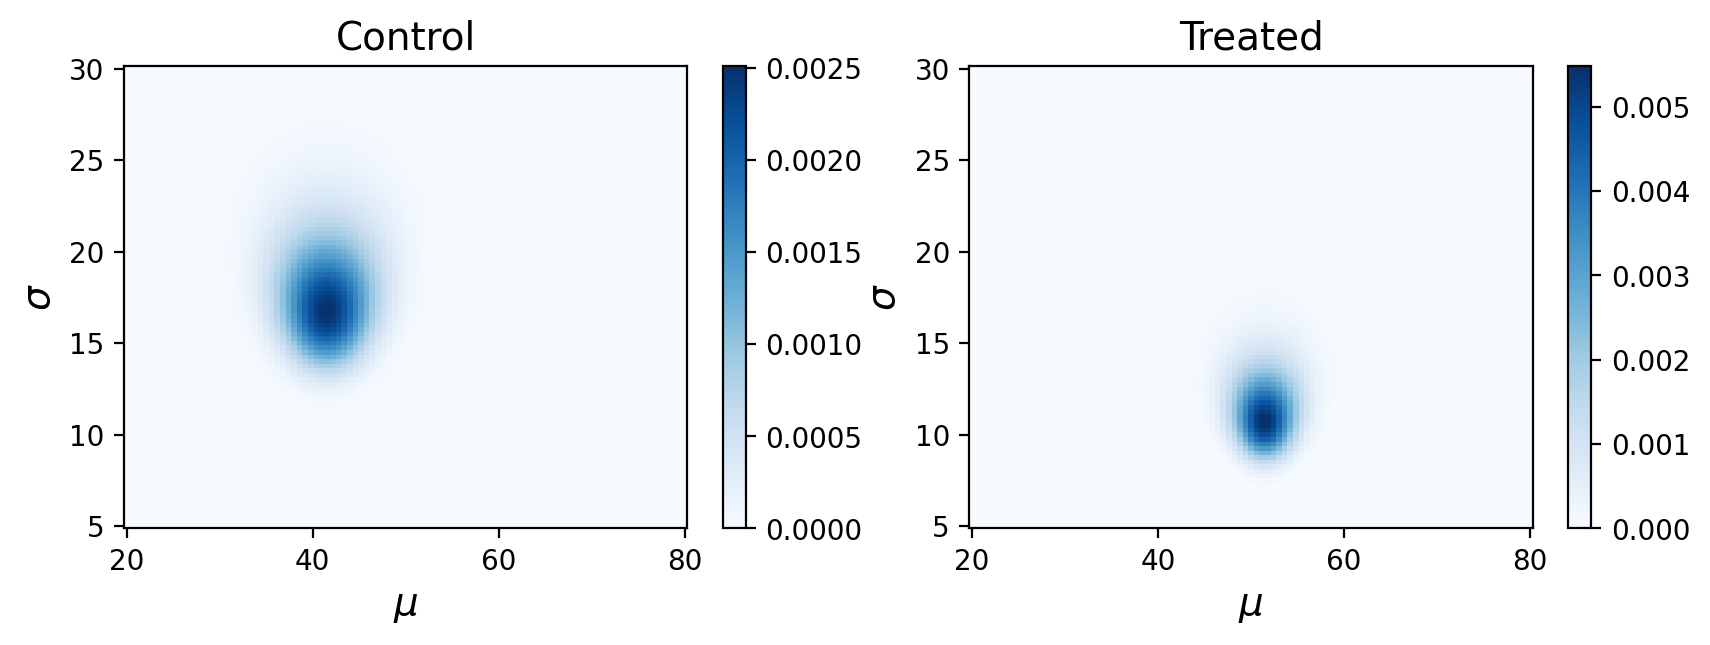

In [2]:
from scipy.stats import randint
from scipy.stats import norm

df = pd.read_csv('images/drp_scores.csv')

# uniform prior for mu
prior_mu  = pd.DataFrame(index = np.linspace(20, 80, num=101))
prior_mu ['probs'] = 1/101

#uniform prior for sigma
prior_sigma  = pd.DataFrame(index = np.linspace(5, 30, num=101))
prior_sigma ['probs'] = 1/101

# multiplies prbabilities from two distributions
def make_joint(pmf1, pmf2):
    """Compute the outer product of two Pmfs."""
    X, Y = np.meshgrid(pmf1['probs'], pmf2['probs'])
    return pd.DataFrame(X * Y, columns=pmf1.index, index=pmf2.index)

prior = make_joint(prior_mu, prior_sigma)

mu_mesh, sigma_mesh, data_mesh = np.meshgrid(prior.columns, prior.index, df.Response)

densities = norm(mu_mesh, sigma_mesh).pdf(data_mesh)

# control
likelihood_control = densities[:,:,df['Treatment']=="Control"].prod(axis=2)

# treated
likelihood_treated = densities[:,:,df['Treatment']=="Treated"].prod(axis=2)

# update with control likelihood
posterior_control = prior * likelihood_control
prob_data = posterior_control.to_numpy().sum()
posterior_control = posterior_control / prob_data

#update with treated likelihood
posterior_treated = prior * likelihood_treated
prob_data = posterior_treated.to_numpy().sum()
posterior_treated = posterior_treated / prob_data

plt.figure(figsize=(10, 3))

ax = plt.subplot(1, 2, 1)
plt.pcolormesh(posterior_control.columns, posterior_control.index, posterior_control, cmap='Blues')
plt.colorbar()
plt.xlabel('$\mu$', size=14)
plt.ylabel('$\sigma$', size=14)
plt.title('Control', size=14);

ax = plt.subplot(1, 2, 2)
plt.pcolormesh(posterior_treated.columns, posterior_treated.index, posterior_treated, cmap='Blues')
plt.colorbar()
plt.xlabel('$\mu$', size=14)
plt.ylabel('$\sigma$', size=14)
plt.title('Treated', size=14);

In [3]:
# calculate means and standard deviations from marginals
mu1 = np.sum(posterior_treated.columns * posterior_treated.sum(axis=0))
mu2 = np.sum(posterior_control.columns * posterior_control.sum(axis=0))
sd1 = np.sum(posterior_treated.index * posterior_treated.sum(axis=1))
sd2 = np.sum(posterior_control.index * posterior_control.sum(axis=1))

# calculate Cohen's d
(mu1 - mu2)/((sd1 + sd2) / 2)

0.66480357657799

This is a reasonably large effect size, though perhaps you would want to collect more data to be more convinced.

### Posterior Distribution of Effect Sizes

We can take this a step further though. We don't have to just use the means of our posterior distributions. We can actually use the entire posterior distributions to get a posterior distribution for Cohen’s effect size!

To do this, you would enumerate all pairs of $\mu$s and $\sigma$s from the two distributions and compute the Cohen's $d$ for each.

However, that would take an awfully long time, so instead we'll just sample 1000 pairs at random (note, don't worry about the details of the sampling, but just note that we draw means and standard deviations proportionally to their probability).

In [4]:
# sample from posterior distributions
sample_treated = np.random.choice(posterior_treated.transpose().stack().index, 1000, p=posterior_treated.transpose().stack())
sample_control = np.random.choice(posterior_control.transpose().stack().index, 1000, p=posterior_control.transpose().stack())

# compute cohens d for all sampled pairs
ds = []
for pair1, pair2 in zip(sample_treated, sample_control):
    mu1, sd1 = pair1 
    mu2, sd2 = pair2
    d = (mu1 - mu2) / ((sd1 + sd2) / 2)
    ds.append(d)
    

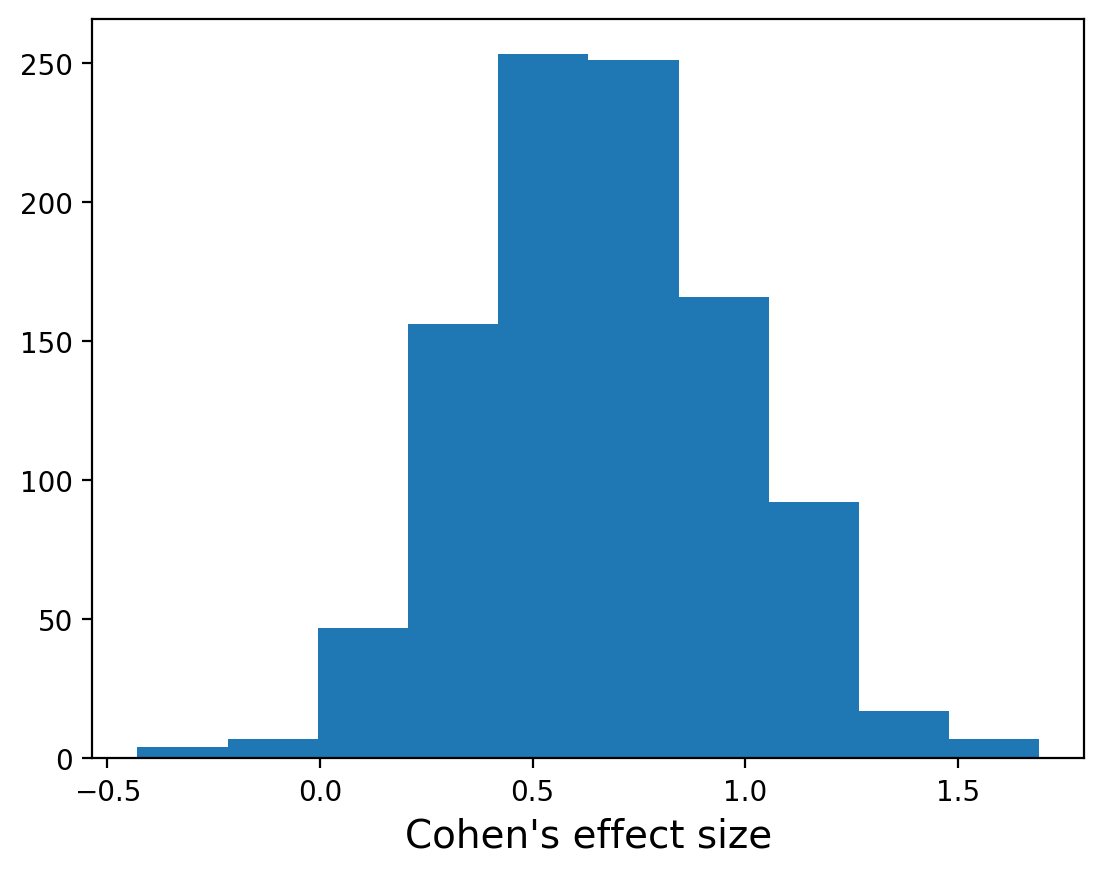

In [5]:
plt.hist(ds)
plt.xlabel("Cohen's effect size", size=14);

We can calculate the mean of this distribution, which should give us a similar result to before:

In [6]:
np.mean(ds)

0.6654546721329487

But now can also get the probabilty the effect size is greater than 0:

In [7]:
(np.asarray(ds)>0).sum()/1000

0.983

And calculate the 90% credible interval for the effect size:

In [8]:
[np.quantile(np.asarray(ds),.05),np.quantile(np.asarray(ds),.95)]

[0.1889763779527559, 1.1638329238329235]

## Empirical Bayes

Empirical Bayes is statistical inference in which the prior probability distribution is estimated from the data. 

Recall that for the train problem we reasoned that a train-operating company with 1000 locomotives is not just as likely as a company with only 1, so we switched from a uniform prior to a power law prior.

But we also noted that perhaps we could also directly use some data (e.g. a survey of train operators).

In some cases, we actually use the very same data we plan to use for our updates. This is in stark contrast with our standard procedue where the prior distribution is fixed before any data are observed (it's always our first step before calculating any likelihoods).

Basically this means using data twice, once for the prior and once for the update. While that might seem problematic (and some data scientists think it is) its a commomly used strategy to construct priors.

For example, lets use the mean and standard deviation of the test scores for the prior distribution of $\mu$ in the control/treatment data we've been using, and from there just run all the same code as before:

In [9]:
# empirical Bayes prior for mu
prior_mu  = pd.DataFrame(index = np.linspace(20, 80, num=101))
prior_mu ['probs'] = norm.pdf(prior_mu.index, np.mean(df.Response), np.std(df.Response))

# uniform prior for sigma
prior_sigma  = pd.DataFrame(index = np.linspace(5, 30, num=101))
prior_sigma ['probs'] = 1/101

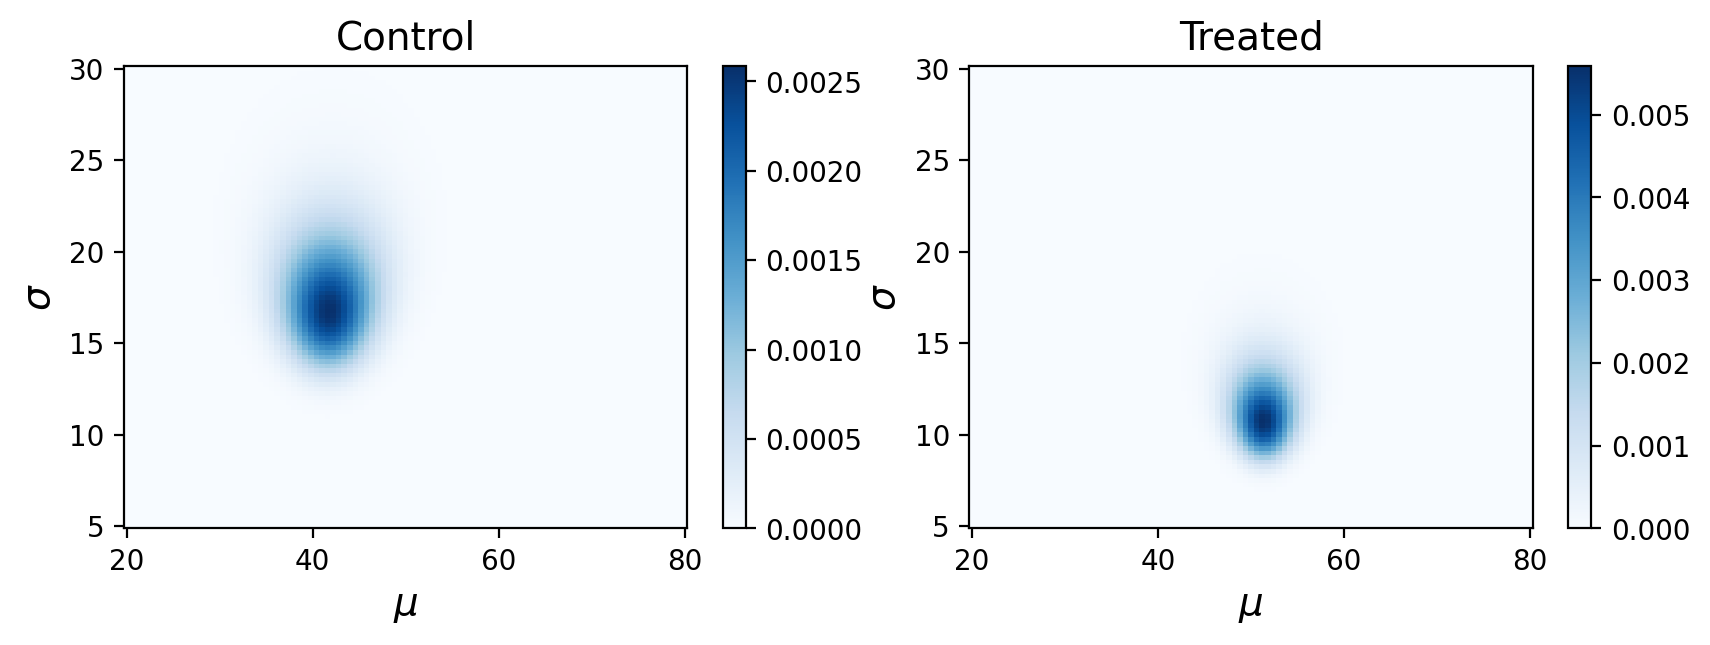

In [10]:
# multiplies prbabilities from two distributions
def make_joint(pmf1, pmf2):
    """Compute the outer product of two Pmfs."""
    X, Y = np.meshgrid(pmf1['probs'], pmf2['probs'])
    return pd.DataFrame(X * Y, columns=pmf1.index, index=pmf2.index)

prior = make_joint(prior_mu, prior_sigma)

mu_mesh, sigma_mesh, data_mesh = np.meshgrid(prior.columns, prior.index, df.Response)

densities = norm(mu_mesh, sigma_mesh).pdf(data_mesh)

# control
likelihood_control = densities[:,:,df['Treatment']=="Control"].prod(axis=2)

# treated
likelihood_treated = densities[:,:,df['Treatment']=="Treated"].prod(axis=2)

# update with control likelihood
posterior_control = prior * likelihood_control
prob_data = posterior_control.to_numpy().sum()
posterior_control = posterior_control / prob_data

#update with treated likelihood
posterior_treated = prior * likelihood_treated
prob_data = posterior_treated.to_numpy().sum()
posterior_treated = posterior_treated / prob_data

plt.figure(figsize=(10, 3))

ax = plt.subplot(1, 2, 1)
plt.pcolormesh(posterior_control.columns, posterior_control.index, posterior_control, cmap='Blues')
plt.colorbar()
plt.xlabel('$\mu$', size=14)
plt.ylabel('$\sigma$', size=14)
plt.title('Control', size=14);

ax = plt.subplot(1, 2, 2)
plt.pcolormesh(posterior_treated.columns, posterior_treated.index, posterior_treated, cmap='Blues')
plt.colorbar()
plt.xlabel('$\mu$', size=14)
plt.ylabel('$\sigma$', size=14)
plt.title('Treated', size=14);

In this case our output is nearly identical. The advantage of the Empirical Bayes approach is that it could potentially find this joint posterior with less data.

Emprical Bayes can take many forms and has varying degrees of success. One common (and less controvertial) way to use it is simply to constrain the search space of your parameters (e.g. calculate the max and min possible $\mu$ and only test those values.

```{margin} 
Image credit: DALLE, prompt: "The cyberpunk grizzly bear problem"
```

## The Grizzly Bear Problem

Finally today, we'll do one more example problem using Bayesian inference.

<center>
    
<img src="images/DALLE-The-Cyberpunk-Grizzly-Bear-Problem.png" width="600px">
    
</center>


In the 90s, Canadian scientists wanted to figure out how many grizzly bears there were in a portion of the rockies. They set out traps to tag (and release) bears (they got 23) . Then they did this a second time and counted how many of the bears they trapped the second (they got 19) time were tagged (i.e. trapped twice, 4 of them were). Using these numbers, how many bears are there?

### Approaching the problem

Let's think about this in terms of two paramters. There's some number of bears $N$ and some probability of trapping any given bear $p$ (let's assume this probabilty doesn't change from round to round). We'll also assume (maybe incorrectly) that the probability a bear is observed in the second round does not depend on whether it was observed in the first round (i.e. we'll assume independence).

If we were trying to find the probability of $N$ bears being trapped once with probabilty $p$, this would follow a simple Binomial distribuion.

It turns out though there there is a **multinomial** distribution, which is just a generalized bionomial to multiple probabilities.

For $N$ trials and $k$ mutually exclusive events each with probability $p$, the probability of any particular combination of numbers of successes $x$ for the various categories is:

$$\frac{N!}{\prod{x_i!}}\prod{p_i^{x_i}} $$


We'll use this to calculate our likelihoods.

### The Prior

We'll start with uniform priors for our two parameters $N$ and $p$. 

In [11]:
from scipy.stats import randint

# uniform prior for N
prior_N  = pd.DataFrame(index = np.linspace(1, 500, num=500))
prior_N ['probs'] = 1/101

#uniform prior for p
prior_p  = pd.DataFrame(index = np.linspace(.0, .99, num=101))
prior_p ['probs'] = 1/101

# multiplies prbabilities from two distributions
def make_joint(pmf1, pmf2):
    """Compute the outer product of two Pmfs."""
    X, Y = np.meshgrid(pmf1['probs'], pmf2['probs'])
    return pd.DataFrame(X * Y, columns=pmf1.index, index=pmf2.index)

prior = make_joint(prior_N, prior_p)

### The Likelihood

Using the multinomial, we can calculate the probability for trapping bears multiple times for each $N$ and $p$.

To apply the multinomial we have to consider the **four** mutually exclusive events for each bear: never caught, caught first time, caught second time, caught both times.


Scenario | Number of Bears | Probability
--- | --- | ---
Never | N - 23 - 19 + 4| $(1-p)^2$
First | 23 - 4 | $p(1-p)$
Second | 19 - 4 | $p(1-p)$
Both | 4 | $p^2$


In [12]:
from scipy.stats import multinomial

likelihood = [[multinomial.pmf([N - 23 - 19 + 4, 23 - 4, 19-4, 4], N, [(1-p)**2,p*(1-p),p*(1-p), p**2])
               for N in prior.columns] for p in prior.index]
likelihood = np.array(likelihood)

### The Update

Same as always:

In [13]:
posterior = prior * likelihood
prob_data = posterior.to_numpy().sum()
posterior = posterior / prob_data

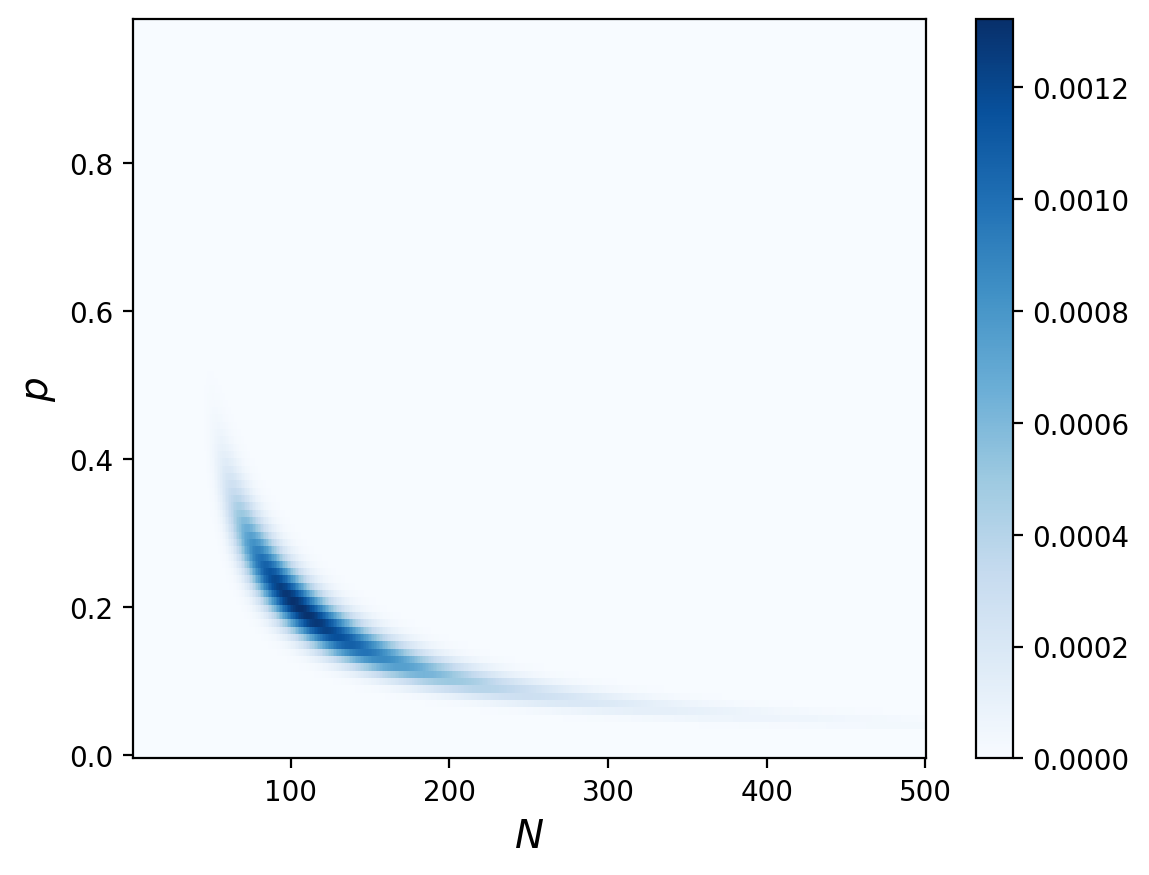

In [14]:
plt.pcolormesh(posterior.columns, posterior.index, posterior, cmap='Blues')
plt.colorbar()
plt.xlabel('$N$', size=14)
plt.ylabel('$p$', size=14);

And let's compute the posterior marginal to look at just the number of bears:

In [15]:
marginal_N = posterior.sum(axis=0)

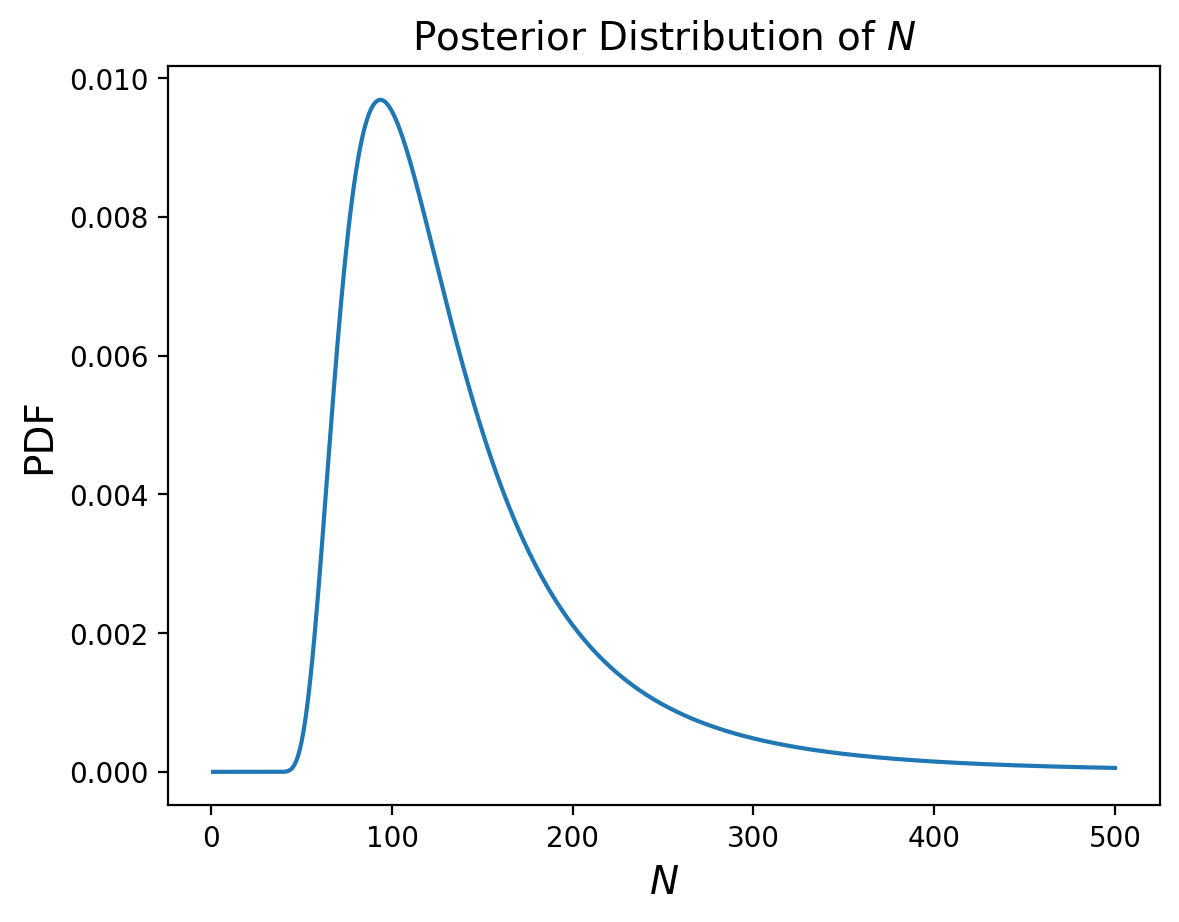

In [16]:
marginal_N.plot()
plt.title('Posterior Distribution of $N$', size=14)
plt.xlabel('$N$', size=14)
plt.ylabel('PDF', size=14);

And now that we have our posterior distribution of N, we can calculuate the MMSE to guess how many bears there are:

In [17]:
np.sum(marginal_N.index*marginal_N)

138.66642251718878